# AgroPest-12 YOLOv11n 

Yolov11 NANO is an evolution of Yolov8 and the latest Yolo model. It introduces attention modules to help the network focus on the most important regions of the image when extracting features. This may help in distinguishing between similar looking classes, which improves detection between similar looking insects in the Agropest-12 dataset.


## Setup

In [2]:
# Imports
from ultralytics import YOLO
import torch
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Device (GPU if available)
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Device: {torch.cuda.get_device_name(0) if device == 0 else 'CPU'}")

Device: NVIDIA GeForce RTX 3060


In [17]:
# Dataset config (adjust path if you move this notebook)
data_yaml_path = Path('../dataset/data.yaml')
with open(data_yaml_path, 'r') as f:
    data = yaml.safe_load(f)
names = data.get('names', [])
print('Classes:', names)

Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


## Model Training

The YOLOv11n model was trained on our dataset for 100 epochs with early stopping patience set to 20. The model uses a batch size of 16 and an input image size of 640×640.

Data augmentation was applied automatically via randaugment, which randomly selects and applies a combination of geometric and photometric transformations during training to improve generalization. Other augmentations such as mosaic, mixup, and HSV adjustments are applied according to the Ultralytics defaults. For exact values, view the cell output of the training cell below. 

The training process optimizes bounding box loss, classification loss, and distribution focal loss. The best model `best.pt` is selected based on validation mAP, which considers both correct localization and correct class prediction. All training outputs are saved to training/results for subsequent evaluation.



In [5]:
# Train YOLOv11n
model = YOLO('yolo11n.pt')
results = model.train(
    data=str(data_yaml_path),
    epochs=100,
    patience=20,
    imgsz=640,
    device=device,
    project='training',
    name='results',
    auto_augment='randaugment',  
    batch=16, 
    seed=42
)
print('Training done.')

New https://pypi.org/project/ultralytics/8.3.227 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.225  Python-3.12.6 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=results, nbs=64, nms=False, opset=

## Validation

This section uses the validation data split from the original dataset. We will observe key performance metrics including accuracy, precision, recall, F1 score, and mAP for detection and classification. The training and validation loss trends for both box localization and classification are also visualized to monitor learning and potential overfitting.

Additional plots such as the confusion matrix, box F1 curves, precision-recall curves, and other relevant metrics will be discussed in detail in the report to provide a deeper analysis of model performance.

Ultralytics 8.3.225  Python-3.12.6 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 667.5319.3 MB/s, size: 54.7 KB)
val: Scanning C:\Users\jerry\OneDrive\Desktop\9517_Group_Project\dataset\valid\labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 8.7it/s 7.9s0.1s
                   all       1095       1341      0.832      0.724       0.77       0.47
                  Ants         96        178      0.805      0.649       0.72      0.296
                  Bees         99        110      0.792      0.791      0.849      0.416
               Beetles         89        100      0.762       0.61      0.664      0.335
          Caterpillars         77        139      0.784      0.417        0.5 

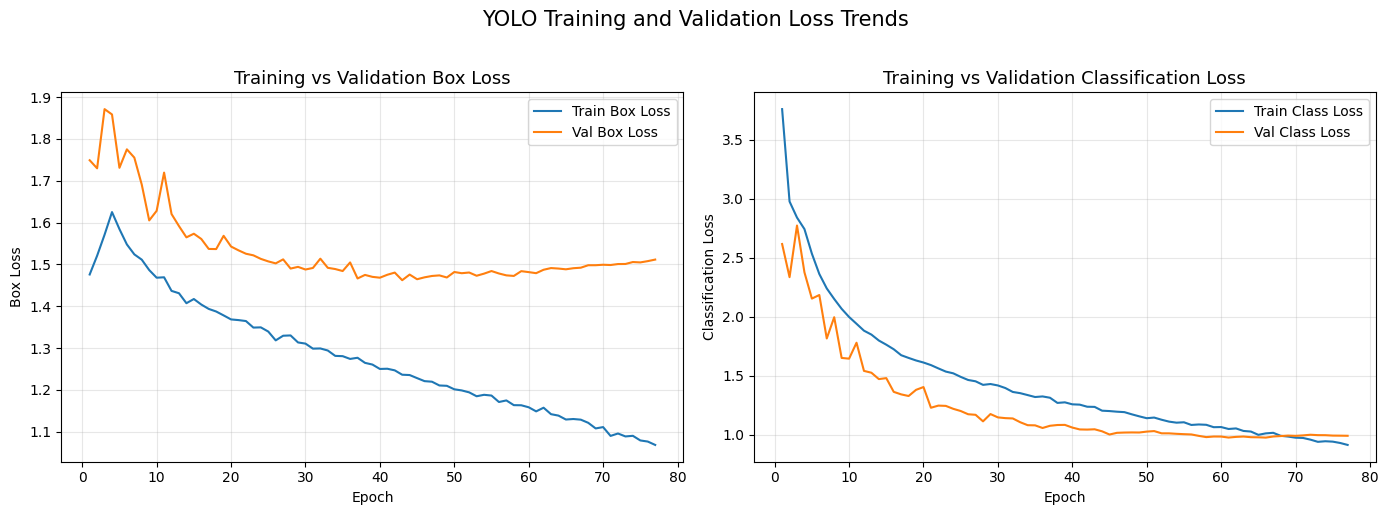

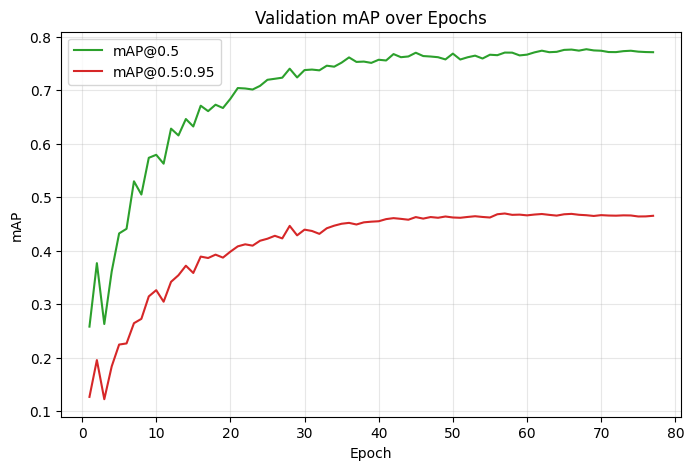

In [19]:
# Load the best model for validation
model = YOLO('training/results/weights/best.pt')
val = model.val(data=str(data_yaml_path), 
            split='val', 
            device=device, 
            imgsz=640,     
            project='validation',
            name='results',
            seed=42
            ) 

P = val.box.mp
R = val.box.mr
# F1 = 2*P*R/(P+R)
cm = val.confusion_matrix.matrix  
A = cm.trace() / cm.sum()  

# Print validation metrics
print('VALIDATION RESULTS:')
print(' Accuracy :', A)
print(' Precision:', P)
print(' Recall   :', R)
# print(' F1       :', F1)
print(' mAP@0.5  :', val.box.map50)
print(' mAP@0.5:0.95:', val.box.map)

# Load training & validation results
df = pd.read_csv('training/results/results.csv')

# Plot training vs validation box loss (detection) and cls loss (classification)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box Loss Plot 
axes[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='tab:blue')
axes[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='tab:orange')
axes[0].set_title('Training vs Validation Box Loss', fontsize=13)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Box Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Classification Loss Plot 
axes[1].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', color='tab:blue')
axes[1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', color='tab:orange')
axes[1].set_title('Training vs Validation Classification Loss', fontsize=13)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Classification Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Display
plt.suptitle('YOLO Training and Validation Loss Trends', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()


# Plot mAP curves
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='tab:green')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP over Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Testing

The model was evaluated on an unseen test set to measure its final performance. Key metrics include precision, recall, F1 score, and mAP for object detection. The confusion matrix highlights how well each class is classified, while mAP@0.5 and mAP@0.5:0.95 quantify overall detection accuracy.

In [21]:
# Evaluate on an unseen test set
model = YOLO('training/results/weights/best.pt')
test = model.val(data=str(data_yaml_path), 
                split='test', 
                device=device, 
                imgsz=640, 
                project='testing',
                name='results',
                seed=42
                )
P = test.box.mp
R = test.box.mr
F1 = 2*P*R/(P+R)
cm = test.confusion_matrix.matrix  
A = cm.trace() / cm.sum()  

print('TEST RESULTS:')
print(' Accuracy :', A)
print(' Precision:', P)
print(' Recall   :', R)
print(' F1       :', F1)
print(' mAP@0.5  :', test.box.map50)
print(' mAP@0.5:0.95:', test.box.map)

Ultralytics 8.3.225  Python-3.12.6 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 88.337.4 MB/s, size: 53.8 KB)
val: Scanning C:\Users\jerry\OneDrive\Desktop\9517_Group_Project\dataset\test\labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 545.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 8.3it/s 4.2s0.1s
                   all        546        689      0.835      0.715       0.78      0.476
                  Ants         54         87      0.866       0.69      0.779      0.347
                  Bees         40         44      0.886      0.864      0.941      0.488
               Beetles         41         44      0.746      0.545      0.687      0.395
          Caterpillars         46         93      0.738      0.473      0.555     

## Advanced Method Development

As part of a deeper analysis into the robustness of our custom YOLOv11 model, we will test its performance against two additional datasets consisting of a mild distortions and strong distortions respectively. The original dataset is processed through a python script `distortion_processing.py`, which applies a combination of Gaussian blur, Gaussian noise, brightness/contrast adjustments, and random occlusions to each image. Mild distortions introduce small changes, while strong distortions apply more extreme noise, heavier blur, larger brightness shifts, and larger occlusion areas.

This allows us to evaluate how well the trained model generalizes to imperfect or altered input images, simulating real-world conditions such as poor lighting, motion blur, sensor noise, or partial occlusion, and potential adversarial attacks. Comparing performance across the original, mildly distorted, and strongly distorted datasets provides insights into the model’s robustness and stability under varying image quality conditions.


## Testing on mildly distorted dataset

In [22]:
# Dataset config 
data_yaml_path = Path('../dataset_mild_distortion/data_mild.yaml')
with open(data_yaml_path, 'r') as f:
    data = yaml.safe_load(f)
names = data.get('names', [])
print('Classes:', names)

Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [24]:
# Evaluate on mildy distorted set
model = YOLO('training/results/weights/best.pt')
test = model.val(data=str(data_yaml_path), 
                split='test', 
                device=device, 
                imgsz=640, 
                project='test_mild',
                name='results',
                seed=42
                )
P = test.box.mp
R = test.box.mr
F1 = 2*P*R/(P+R)
cm = test.confusion_matrix.matrix  
A = cm.trace() / cm.sum()  

print('TEST RESULTS ON MILDLY DISTORTED DATA:')
print(' Accuracy :', A)
print(' Precision:', P)
print(' Recall   :', R)
print(' F1       :', F1)
print(' mAP@0.5  :', test.box.map50)
print(' mAP@0.5:0.95:', test.box.map)

Ultralytics 8.3.225  Python-3.12.6 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 199.7113.1 MB/s, size: 157.8 KB)
val: Scanning C:\Users\jerry\OneDrive\Desktop\9517_Group_Project\dataset_mild_distortion\test\labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 567.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 8.0it/s 4.4s0.1s
                   all        546        689      0.842      0.708       0.77      0.467
                  Ants         54         87      0.851      0.713      0.795      0.347
                  Bees         40         44      0.873      0.841      0.917      0.464
               Beetles         41         44      0.925      0.563      0.699      0.405
          Caterpillars         46         93      0.776      0.

## Testing on strongly distorted dataset

In [25]:
# Dataset config 
data_yaml_path = Path('../dataset_strong_distortion/data_strong.yaml')
with open(data_yaml_path, 'r') as f:
    data = yaml.safe_load(f)
names = data.get('names', [])
print('Classes:', names)

Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [27]:
# Evaluate on strongly distorted set
model = YOLO('training/results/weights/best.pt')
test = model.val(data=str(data_yaml_path), 
                split='test', 
                device=device, 
                imgsz=640, 
                project='test_strong',
                name='results',
                seed=42
                )
P = test.box.mp
R = test.box.mr
F1 = 2*P*R/(P+R)
cm = test.confusion_matrix.matrix  
A = cm.trace() / cm.sum()  

print('TEST RESULTS ON STRONGLY DISTORTED DATA:')
print(' Accuracy :', A)
print(' Precision:', P)
print(' Recall   :', R)
print(' F1       :', F1)
print(' mAP@0.5  :', test.box.map50)
print(' mAP@0.5:0.95:', test.box.map)

Ultralytics 8.3.225  Python-3.12.6 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.30.0 ms, read: 31.111.8 MB/s, size: 243.3 KB)
val: Scanning C:\Users\jerry\OneDrive\Desktop\9517_Group_Project\dataset_strong_distortion\test\labels... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 684.1it/s 0.8s0.1s
val: New cache created: C:\Users\jerry\OneDrive\Desktop\9517_Group_Project\dataset_strong_distortion\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 8.2it/s 4.3s0.1s
                   all        546        689      0.401      0.184       0.18     0.0971
                  Ants         54         87       0.26      0.149     0.0931      0.031
                  Bees         40         44          1          0    0.00708    0.00346
               Beetles         41   